In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Optional

In [2]:
file = "../data/SSCURVES(1-61).xlsx"
xls = pd.ExcelFile(file)

In [3]:
def calculate_smallest_range(stop: Optional[int] = None):
    """
    Returns:
        [range, idx, number of points]
    """
    smallest_stress_range = [np.inf, None, None] # [range, idx, number of points]
    for sheet in xls.sheet_names:
        df = pd.read_excel(file, sheet_name=sheet)
        df = df.dropna(subset=['Strain', 'Stress'])

        # TODO: Some data MUST be excluded, right? There are dataseries with less than 10 points.
        # I don't believe those could be good...
        if len(df) < 15:
            continue
        low = df['Stress'].min()
        high = df['Stress'].max()
        stress_range = high - low
        if stress_range < smallest_stress_range[0]:
            smallest_stress_range = [stress_range, sheet, len(df)]

    print(f"Case {smallest_stress_range[1]} has the shortest strain range of {smallest_stress_range[0]} with {smallest_stress_range[2]} points.")

    return smallest_stress_range

In [4]:
def make_data_matrix(smallest_stress_range: list[float, int, int], stop: Optional[int] = None):    
    df_list = []
    for sheet in xls.sheet_names:
        if stop and len(df_list) == stop:
            break
        df_list.append(pd.read_excel(file, sheet_name=sheet))

    y_dflist = []
    xc = int(smallest_stress_range[1])

    for i in range(len(df_list)):
        interpolated = np.interp(df_list[xc]['Stress'], df_list[i]['Stress'], df_list[i]['Strain'])
        y_dflist.append(interpolated)

    X = np.array(y_dflist)

    return X

In [5]:
def calculate_components(X, number):
    components = PCA(n_components=3).fit(X).components_
    scores = PCA(n_components=3).fit(X).explained_variance_
    mean = PCA(n_components=3).fit(X).mean_

    return components, scores, mean

In [12]:
def plot_spread_of_set(stop: Optional[int] = None):
    smallest_stress_range = calculate_smallest_range(stop)
    X = make_data_matrix(smallest_stress_range, stop)

    components, scores, mean = calculate_components(X, 3)

    variances = []
    distances_array = []
    for i, mean_i in enumerate(mean):
        distances = np.abs(mean_i - X[i])
        distances_array.append(distances)
        var = np.var(distances)
        variances.append(var)

    plt.subplot(121)
    plt.xlabel('i')
    plt.ylabel('variance')
    plt.plot(variances)
    plt.ylim([0, 0.018])

    plt.subplot(122)
    plt.hist(distances, bins=X.shape[1])
    plt.xlabel('distance')
    plt.ylabel('count')
    plt.ylim([0, 4.5])

    plt.tight_layout()

    plt.show()


    

Case 32 has the shortest strain range of 0.39937500000000004 with 44 points.


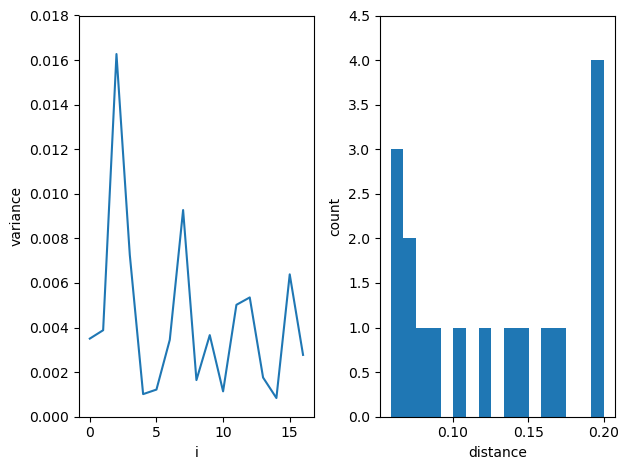

In [13]:
plot_spread_of_set()

Case 32 has the shortest strain range of 0.39937500000000004 with 44 points.


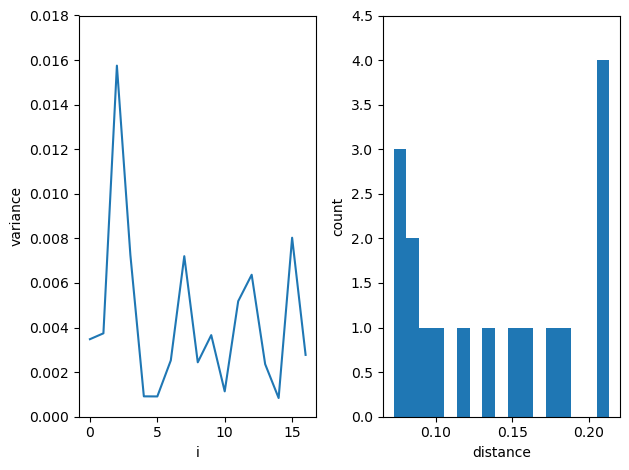

In [14]:
plot_spread_of_set(stop=35) # 35 ~ 60% of all data.